# Gaussian Dispersion Models

Gaussian dispersion models are some of the simplest dispersion models and are used routinely for neutrally buoyant releases as well as for quick order-of-magnitude estimates for all kinds of releases. They are also typically the limiting behaviour for dense gas models as the density of the cloud trends towards the ambient conditions.

In this example the scenario is simply a given, to show how `GasDispersion.jl` might be used.

In [1]:
using GasDispersion

using Plots

In [2]:
scenario = Scenario(
    1.0,   # mass emission rate, kg/s
    10.0,  # release duration, s
    0.25,  # jet diameter, m
    15.67, # jet velocity, m/s
    1.3,   # jet density, kg/m^3
    101325,# release_pressure, Pa
    450,   # release temperature, K
    1.0,   # release height, m
    1.5,   # windspeed, m/s
    1.225, # ambient density, kg/m^3
    101325,# ambient pressure, Pa
    298.15,# ambient temperature, K
    "E",   # pasquill stability class
)

Scenario(1.0, 10.0, 0.25, 15.67, 1.3, 101325, 450, 1.0, 1.5, 1.225, 101325, 298.15, "E")

## Gaussian Plume

For this given scenario we assume a continuous release from a point at x=0, y=0, z=h. The windspeed is taken at the release height, but the model implicitly assumes it is constant everywhere.

In [3]:
Q = scenario.mass_emission_rate
Dⱼ = scenario.jet_diameter
h = scenario.release_height
uⱼ = scenario.jet_velocity
Tᵣ = scenario.release_temperature

u = scenario.windspeed
Tₐ = scenario.ambient_temperature

298.15

### Atmospheric Stability

The atmospheric stability relates to the vertical mixing of the air due to a temperature gradient, during the day air temperature decreases with elevation and this temperature gradient induces a vertical flow that leads to vertical mixing.

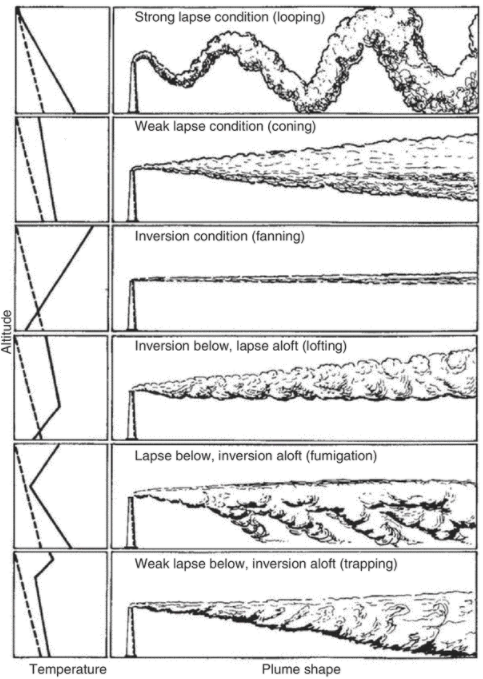

This is captured by the atmospheric stability parameter $s$ which is given by
 
$$ s = \frac{g}{T_a} { \partial \theta \over \partial z } $$

Where $ \partial \theta \over \partial z $ is the lapse rate in K/m

A default lapse rate can be used for class E stability, ${ \partial \theta \over \partial z } = 0.020 K/m$

In [4]:
g = 9.80616  # gravity, m/s^2
Γ = 0.020    # default lapse rate K/m
s = (g/Tₐ)*Γ # stability


0.0006578004360221366

### Effective Stack Height

The plume rising out of a stack will rise higher than the stack height due to buoyancy and because the plume is ejected with some kinetic energy. What follows is essentially a simplified version of the Brigg's model for stable plume rise.

As a first check we verify that stack downwash will not be relevant. For low momentum releases the effective stack height of the plume is reduced by vortices shed downwind of the stack that pull the plume downwards. This is only really relevant when $u_j < 1.5 u$

Where $u_j$ is the stack exit velocity and $u$ the windspeed at the stack.

In [5]:
uⱼ > 1.5u

true

The following assumes a *stable* plume rise, Pasquill stability class F corresponds to very stable conditions.

The next step is to determine whether not the plume rise is dominated by buoyancy or by momentum. For buoyant plume rise to dominate the actual temperature difference -- the difference between the release temperature and the ambient temperature -- must be greater than a critical temperature difference $\left( \Delta T \right)_c $

$$ T_r - T_a \gt \left( \Delta T \right)_c = 0.019582 T_r u_j \sqrt{s} $$


In [6]:
ΔTc = 0.019582*Tᵣ*uⱼ* √(s)

(Tᵣ - Tₐ) > ΔTc

true

In this case buoyant plume rise is dominant, and the stable plume rise equation is

$$ \Delta h = 2.6 \left( F_b \over u_s s \right)^{1/3} $$

where $\Delta h$ is the increase in effective stack height due to plume rise, and $F_b$ is the buoyancy flux parameter

$$ F_b = g v_s D_s^2 { \left( T_r - T_a \right) \over 4 T_r } $$

Plume rise is not instantaneous, however, and the distance to the final rise, $x_f$ is given by

$$ x_f = 2.0715 {u_s \over \sqrt{s}} $$

with any distance closer to the source than $x_f$ experiencing a lesser plume rise, given by

$$ \Delta h = 1.60 \left( F_b x^2 \over u_s^3 \right)^{1/3} $$

this can be put together into a function that calculates $ \Delta h$ as a function of distance *x*

In [7]:
Fb =  g*uⱼ*(Dⱼ^2)*(Tᵣ - Tₐ)/(4Tᵣ)

function Δh(x)
    xf = 2.0715*u/√(s)
    stable_rise = 2.6*(Fb/(u*s))^(1/3)
    
    if x < xf
        return min( 1.60*(Fb*x^2/u^3)^(1/3), stable_rise)
    else
        return stable_rise
    end
    
end

Δh (generic function with 1 method)

### Pasquill-Gifford Model

The plume will expand in the crosswind and vertical directions, and this is captured with the dispersion parameters $\sigma_{y}$ and $\sigma_{z}$. These are functions of the downwind distance *x*.

$$ \sigma_{y} = \delta x^{\beta} $$

$$ \sigma_{z} = \delta x^{\beta} \exp(\gamma \ln(x)^2) $$

With the constants tabulated based on the Pasquill stability class criteria.

These particular correlations come from:
+ Spicer, T.O., and J.A. Havens, *User's Guide for the DEGADIS 2.1 Dense Gas
Dispersion Model*, EPA-450/4-89-019, November 1989, pp 45-46
+Seinfeld, J.H., *Atmospheric Chemistry and Physics of Air Pollution*, John
Wiley and Sons, New York, 1986


In [8]:
σy(x) = (0.102*(11.4/600)^0.2)*x^0.9

σz(x) = 0.02275*(x^1.3010)*exp(-0.0450*log(x)^2)

σz (generic function with 1 method)

### Gaussian Plume Model

The gaussian plume model assumes that concentration profile in the crosswind (y) and vertical (z) directions follow gaussian distributions with dispersions $\sigma_y$ and $\sigma_z$, respectively. This model can be derived from an advection-diffusion equation, or simply taken as a given.

The basic gaussian would have the plume expand downward beyond the ground, to correct for this an additional term for *ground reflection* is added. This is equivalent to adding a mirror image source reflected across the x-z plane, and causes mass to accumulate along the ground instead of simply disappearing (as would happen in the naive case)

$$ c_{plume} = {Q \over 2 \pi u \sigma_{y} \sigma_{z} }
\exp \left[ -\frac{1}{2} \left( y \over \sigma_{y} \right)^2 \right]
\left\{ \exp \left[ -\frac{1}{2} \left( { z -h } \over \sigma_{z} \right)^2 \right] + \exp \left[ -\frac{1}{2} \left( { z + h } \over \sigma_{z} \right)^2 \right] \right\} $$

A similar term can be added to reflect back mass at higher elevations, due to inversions, this is not included in this model.

The effect of plume rise is to shift the release from the actual stack height to an effective stack height $h_e = h + \Delta h$ with $\Delta h$ given by the plume rise model already discussed. Additionally the dispersion is adjusted by the following

$$ \sigma_{ze}^2 = \left( \Delta h \over 3.5 \right)^2 + \sigma_z^2 $$

$$ \sigma_{ye}^2 = \left( \Delta h \over 3.5 \right)^2 + \sigma_y^2 $$

and the final model of concentration is given using these effective parameters.

In [9]:
function c_plume(x, y, z)
    hₑ  = h + Δh(x)
    σyₑ = √( (Δh(x)/3.5)^2 + σy(x)^2 )
    σzₑ = √( (Δh(x)/3.5)^2 + σz(x)^2 )
    
    C = (Q/(2*π*u*σyₑ*σzₑ)) *
         exp(-0.5*(y/σyₑ)^2) *
         ( exp(-0.5*((z-hₑ)/σzₑ)^2) + exp(-0.5*((z+hₑ)/σzₑ)^2) )
    
end

c_plume (generic function with 1 method)

This is exactly what the `GasDispersion.jl` gaussian plume model generates for this scenario.

In [10]:
gauss_plume = plume(scenario, model="gaussian", plumerise=true, downwash=true)

(::GasDispersion.var"#gaussian_plume#20"{GasDispersion.var"#5#7"{Float64}, GasDispersion.var"#2#3", GasDispersion.var"#10#15"{Float64, Float64}, Float64, Float64}) (generic function with 2 methods)

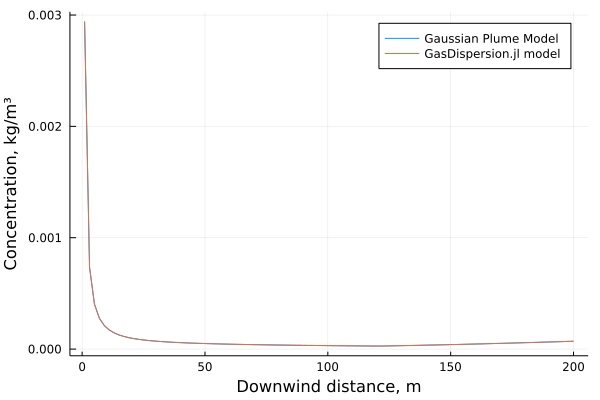

In [11]:
xs = range(1, 200, length = 100)

plot(xs, x->c_plume(x, 0, h), lab="Gaussian Plume Model")
plot!(xs, x->gauss_plume(x, 0, h), lab="GasDispersion.jl model")
plot!(ylabel="Concentration, kg/m³", xlabel="Downwind distance, m")


Using the `Plots` library contour plots showing the concentration profile of the plume can be easily generated.

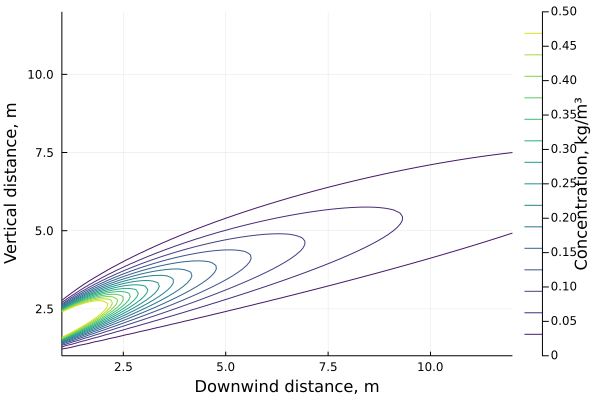

In [12]:
xs = range(1, 12, length=100)
zs = range(1, 12, length=100)

contour(xs, zs, (x,z)->gauss_plume(x, 0, z), c=:viridis, fill=false,
        clim=(0,0.5), colorbar_title="Concentration, kg/m³",
        xlabel="Downwind distance, m",
        ylabel="Vertical distance, m")

# Gaussian Puff

For this example we assume the same scenario, unlike the plume which assumed a continuous release the puff model assumes the entire mass is released instantaneously.

In [13]:
Q = scenario.mass_emission_rate
tᵣ = scenario.release_duration
m = Q*tᵣ # total mass released

Dⱼ = scenario.jet_diameter
h = scenario.release_height
uⱼ = scenario.jet_velocity
Tᵣ = scenario.release_temperature

u = scenario.windspeed
Tₐ = scenario.ambient_temperature

298.15

This model does not account for any buoyant or momentum driven motion of the cloud, it merely moves along with the ambient windspeed -- which is assumed constant everywhere. The concentration profile is given by a series of gaussians with dispersions $\sigma_x$, $\sigma_y$, and $\sigma_z$, which are found from correlations tabulated per stability class

$$ c_{puff} = { m \over { (2 \pi)^{3/2} \sigma_x \sigma_y \sigma_z } } 
\exp \left( -\frac{1}{2} \left( {x - ut} \over \sigma_x \right)^2 \right) 
\exp \left( -\frac{1}{2} \left( {y} \over \sigma_y \right)^2 \right) \\
\times \left[ \exp \left( -\frac{1}{2} \left( {z - h} \over \sigma_z \right)^2 \right) 
+ \exp \left( -\frac{1}{2} \left( {z + h} \over \sigma_z \right)^2 \right)\right]$$

Similarly to the plume model, a ground reflection term is included to correct for the fact that material cannot pass through the ground.

The model assumes the initial release is a single point, with no dimensions. It is often worthwhile to estimate the initial dimensions of the cloud and calculate a *virtual* emission point to compensate for this. This is not implemented currently in `GasDispersion.jl`.

Unlike the plume model, this concentration is a function of time.

In [14]:
σx_puff(x) = 0.04*x^0.92
σy_puff(x) = 0.04*x^0.92
σz_puff(x) = 0.10*x^0.65

function c_puff(x,y,z,t)
    sx = σx_puff(x)
    sy = σy_puff(x)
    sz = σz_puff(x)
    
    C1 = m / ( (2*π)^(1.5) * sx * sy * sz )
    C2 = exp(-0.5*((x-u*t)/sx)^2)
    C3 = exp(-0.5*(y/sy)^2)
    C4 = ( exp(-0.5*((z-h)/sz)^2) + exp(-0.5*((z+h)/sz)^2) )
    
    return C1*C2*C3*C4
end

c_puff (generic function with 1 method)

In [15]:
gauss_puff = puff(scenario, model="gaussian")

(::GasDispersion.var"#gaussian_puff#21"{GasDispersion.var"#6#8", GasDispersion.var"#2#3", GasDispersion.var"#2#3", Float64, Float64, Float64}) (generic function with 1 method)

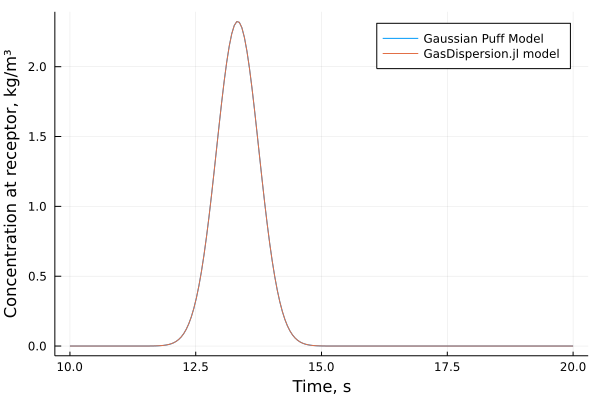

In [16]:
ts = range(10, 20, length = 200)

plot(ts, t->c_puff(20, 0, h, t), lab="Gaussian Puff Model")
plot!(ts, t->gauss_puff(20, 0, h, t), lab="GasDispersion.jl model")
plot!(ylabel="Concentration at receptor, kg/m³", xlabel="Time, s")

Using the `Plots` library an animated contour plot showing the movement of the cloud downwind can be generated.

┌ Info: Saved animation to 
│   fn = /home/allan/.julia/dev/GasDispersion/examples/tmp.gif
└ @ Plots /home/allan/.julia/packages/Plots/OfMyZ/src/animation.jl:104


Plots.AnimatedGif("/home/allan/.julia/dev/GasDispersion/examples/tmp.gif")
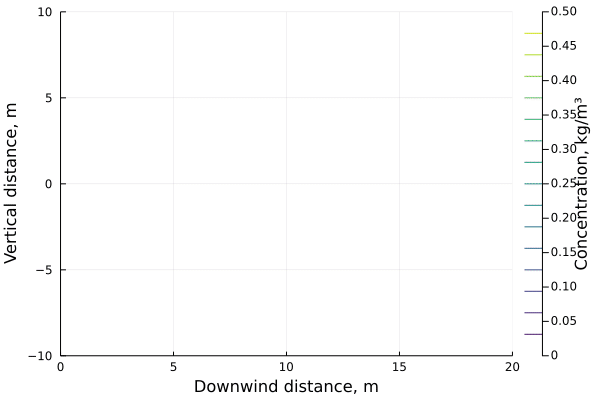

In [17]:
xs = range(0, 20, length=100)
ys = range(-10, 10, length=100)

@gif for i ∈ 1:100
    t = (i/100)*(20/u)

    contour(xs, ys, (x, y)-> gauss_puff(x, y, h, t), c=:viridis, fill=false,
        clim=(0,0.5), colorbar_title="Concentration, kg/m³",
        xlabel="Downwind distance, m",
        ylabel="Vertical distance, m")


end